1. Use the same dataset from the previous task
2. Reuse validation strategy and preprocessing without changes
3. Train xgboost model
4. Train lightgbm model
5. Train catboost model
6. Compare performance on local validation and on test set on kaggle

In [1]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

In [2]:
csv_train = r'https://drive.usercontent.google.com/download?id=1RIKv1X_XWYAPCsmH6UPKOue3nHu1pkGJ&export=download&authuser=0'
csv_test = r'https://drive.usercontent.google.com/download?id=1dNHk0lq04yQDpfz3_lf4PX2rZEQWrHnp&export=download&authuser=0&confirm=t&uuid=668130f8-48df-4ba3-ac54-d187c7f65b60&at=AO7h07cWJg4cofkmU9mkqR7XAEl7:1724719828412'

train_raw = pd.read_csv(csv_train)
test_raw = pd.read_csv(csv_test)

In [3]:
age_mean_train = train_raw['Age'].mean()
embarked_top_train = train_raw['Embarked'].value_counts().index[0]
fare_mean_train = train_raw['Fare'].mean()

def enhance_features(data):
    data = data.copy().set_index('PassengerId')
        
    data['missing_age'] = data['Age'].isnull().astype(int)
    data['missing_fare'] = data['Fare'].isnull().astype(int)
    data['missing_embarked'] = data['Embarked'].isnull().astype(int)
    data['missing_cabin'] = data['Cabin'].isnull().astype(int)
    
    data['title'] = data['Name'].str.extract(r'[^,]*, ([^.]*)\. .*')
    data['ticket_prefix'] = data['Ticket'].str.extract(r'(.*) \d*').replace('\.', '', regex=True).fillna('')    
    data['cabin_letter'] = data['Cabin'].str.extract(r'([A-Za-z]*)\d*')
    
    data['Age'] = data['Age'].fillna(age_mean_train)
    data['Fare'] = data['Fare'].fillna(fare_mean_train)    
    data['Embarked'] = data['Embarked'].fillna(embarked_top_train)
    data['cabin_letter'] = data['cabin_letter'].fillna('Unknown')    
    
    return data.drop(columns=['Name', 'Ticket', 'Cabin'])


train_X = enhance_features(train_raw.drop(columns=['Survived']))
train_y = train_raw['Survived']

test_X = enhance_features(test_raw)

train_X

<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
C:\Users\De\AppData\Local\Temp\ipykernel_25232\1105311691.py:14: SyntaxWarning: invalid escape sequence '\.'
  data['ticket_prefix'] = data['Ticket'].str.extract(r'(.*) \d*').replace('\.', '', regex=True).fillna('')


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,missing_age,missing_fare,missing_embarked,missing_cabin,title,ticket_prefix,cabin_letter
PassengerId,,,,,,,,,,,,,,
1,3,male,22.000000,1,0,7.2500,S,0,0,0,1,Mr,A/5,Unknown
2,1,female,38.000000,1,0,71.2833,C,0,0,0,0,Mrs,PC,C
3,3,female,26.000000,0,0,7.9250,S,0,0,0,1,Miss,STON/O2,Unknown
4,1,female,35.000000,1,0,53.1000,S,0,0,0,0,Mrs,,C
5,3,male,35.000000,0,0,8.0500,S,0,0,0,1,Mr,,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,male,27.000000,0,0,13.0000,S,0,0,0,1,Rev,,Unknown
888,1,female,19.000000,0,0,30.0000,S,0,0,0,0,Miss,,B
889,3,female,29.699118,1,2,23.4500,S,1,0,0,1,Miss,W/C,Unknown


# XGB

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['Sex', 'Embarked', 'title', 'ticket_prefix', 'cabin_letter']),
    ],
    remainder='passthrough'
)

In [24]:
class XGBEarlyStoppingWrapper:
    def __init__(self, classifier):
        self.classifier = classifier

    def __getattr__(self, name):
        return getattr(self.classifier, name)

    def fit(self, X, y, **kwargs):
        eval_set = [(X, y)]
        return self.classifier.fit(
            X, y,
            early_stopping_rounds=2,
            eval_set=eval_set,
            eval_metric='error',            
            **kwargs
        )

    def predict(self, X):
        return self.classifier.predict(X)

    def score(self, X, y):
        return self.classifier.score(X, y)
    
    def set_params(self, **params):
        self.classifier.set_params(**params)
        
    def get_params(self, **params):
        return self.classifier.get_params(**params)


cv = StratifiedKFold(n_splits=30, shuffle=True, random_state=42)
scoring = make_scorer(f1_score)

pipeline_xgb_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBEarlyStoppingWrapper(xgb.XGBClassifier(random_state=0, n_jobs=-1)))
])

In [28]:
%%time   

param_grid_xgb_2 = {
    'classifier__n_estimators': [5, 10, 50],
    #'classifier__learning_rate': [0.1, 0.5, 1],
    'classifier__max_depth': [5, 20],
    'classifier__alpha': [0.1, 1],
    'classifier__lambda': [0.1, 1],
    'classifier__gamma': [0.1, 1],
    'classifier__subsample': [0.5, 0.8],
    'classifier__colsample_bytree': [0.7, 0.9],
}

grid_search_xgb_2 = GridSearchCV(pipeline_xgb_2, param_grid_xgb_2, cv=cv, scoring=scoring, n_jobs=-1, verbose=2)
grid_search_xgb_2.fit(train_X, train_y)

print('Best_params', grid_search_xgb_2.best_params_)
print(f'F1 score on cross-validation: {grid_search_xgb_2.best_score_}')
print(f'F1 score on all train data: {f1_score(grid_search_xgb_2.predict(train_X), train_y)}')

Fitting 30 folds for each of 192 candidates, totalling 5760 fits
Best_params {'classifier__alpha': 1, 'classifier__colsample_bytree': 0.7, 'classifier__gamma': 0.1, 'classifier__lambda': 1, 'classifier__max_depth': 5, 'classifier__n_estimators': 50, 'classifier__subsample': 0.8}
F1 score on cross-validation: 0.7749688366271127
F1 score on all train data: 0.8885542168674698
CPU times: total: 16.9 s
Wall time: 44.5 s


Other runs:

Fitting 20 folds for each of 1728 candidates, totalling 34560 fits
Best_params {'classifier__alpha': 0.01, 'classifier__gamma': 0, 'classifier__lambda': 1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 50}
F1 score on cross-validation: 0.781997345201234
F1 score on all train data: 0.9175412293853074
CPU times: total: 1min 33s
Wall time: 3min 37s

Fitting 30 folds for each of 7776 candidates, totalling 233280 fits
Best_params {'classifier__alpha': 1, 'classifier__colsample_bytree': 0.8, 'classifier__gamma': 1, 'classifier__lambda': 0.01, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 20, 'classifier__n_estimators': 100, 'classifier__subsample': 0.5}
F1 score on cross-validation: 0.7883285787862445
F1 score on all train data: 0.8466257668711656
CPU times: total: 13min 50s
Wall time: 37min 52s

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

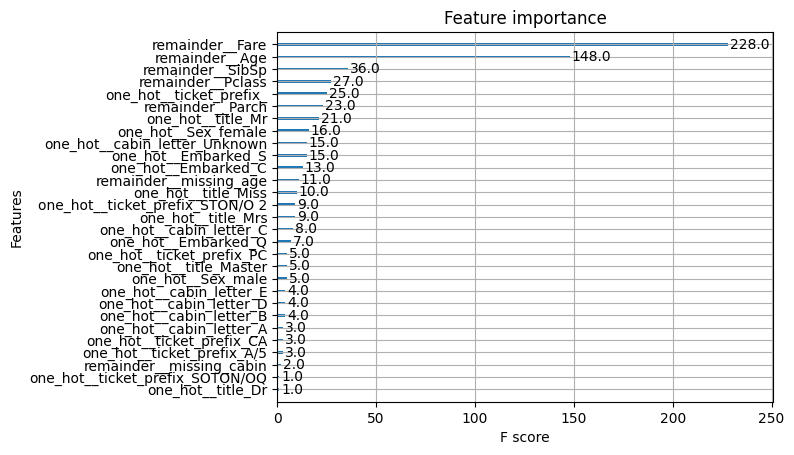

In [30]:
steps = grid_search_xgb_2.best_estimator_.named_steps
steps['classifier'].get_booster().feature_names = steps['preprocessor'].get_feature_names_out().tolist()
xgb.plot_importance(steps['classifier'], importance_type='weight')

In [29]:
%%time

pipeline_xgb_1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=0, n_jobs=-1))
])

param_grid_xgb_1 = {
    'classifier__n_estimators': [5, 10, 50],
    #'classifier__learning_rate': [0.1, 0.5, 1],
    'classifier__max_depth': [5, 20],
    'classifier__alpha': [0.1, 1],
    'classifier__lambda': [0.1, 1],
    'classifier__gamma': [0.1, 1],
    'classifier__subsample': [0.5, 0.8],
    'classifier__colsample_bytree': [0.7, 0.9],
    
    # 'classifier__n_estimators': [5, 10, 20, 50],
    # 'classifier__learning_rate': [0.1, 0.5, 1],
    # 'classifier__max_depth': [3, 5, 7, 10],
    # 'classifier__alpha': [0.01, 0.1, 1],
    # 'classifier__lambda': [0.01, 0.1, 1],
    # 'classifier__gamma': [0, 0.1, 1, 5],
    
    # Give no gain
    # 'classifier__subsample': [0.5, 0.6, 0.7, 0.8, 1.0],
    # 'classifier__colsample_bytree': [0.7, 0.8, 1.0],
}

grid_search_xgb_1 = GridSearchCV(pipeline_xgb_1, param_grid_xgb_1, cv=cv, scoring=scoring, n_jobs=-1, verbose=2)
grid_search_xgb_1.fit(train_X, train_y)

print('Best_params', grid_search_xgb_1.best_params_)
print(f'F1 score on cross-validation: {grid_search_xgb_1.best_score_}')
print(f'F1 score on all train data: {f1_score(grid_search_xgb_1.predict(train_X), train_y)}')

Fitting 30 folds for each of 192 candidates, totalling 5760 fits
Best_params {'classifier__alpha': 1, 'classifier__colsample_bytree': 0.7, 'classifier__gamma': 0.1, 'classifier__lambda': 1, 'classifier__max_depth': 5, 'classifier__n_estimators': 50, 'classifier__subsample': 0.8}
F1 score on cross-validation: 0.7749688366271127
F1 score on all train data: 0.8885542168674698
CPU times: total: 16.9 s
Wall time: 41.8 s


c:\Python\envs\ds1\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Early stoping hasn't provided much performance gain. Maybe on larger dataset it could.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

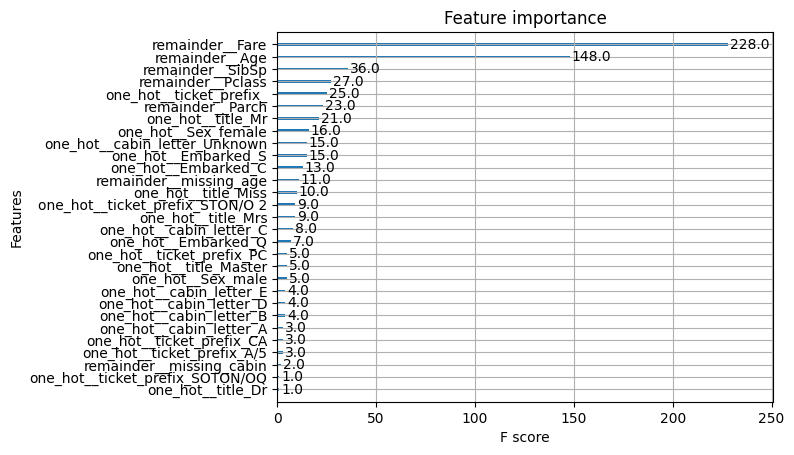

In [33]:
steps = grid_search_xgb_1.best_estimator_.named_steps
steps['classifier'].get_booster().feature_names = steps['preprocessor'].get_feature_names_out().tolist()
xgb.plot_importance(steps['classifier'], importance_type='weight')

### Experiment with xgb.cv

In [34]:
grid_search_xgb_1.best_estimator_.named_steps['classifier'].get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.7,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.1,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 50,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 0,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'alpha': 1,
 'lambda': 1}

In [35]:
train_X_transformed = preprocessor.fit_transform(train_X)
feature_names = list(preprocessor.get_feature_names_out())
xgb_train = xgb.DMatrix(train_X_transformed, train_y, feature_names=feature_names)

xgb_test = xgb.DMatrix(preprocessor.transform(test_X), feature_names=feature_names)

parameters = {
    "n_jobs": -1,
    "objective": "binary:logistic",
    "random_state": 42,
    "eval_metric": "error",
    
    #"max_depth": 10,
    "eta": 0.1,
    "subsample": 0.5,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.1,
    #"reg_lambda": 1,
    "gamma": 0.1,    
}
results = xgb.cv(parameters, xgb_train, num_boost_round=20, folds=cv, verbose_eval=10, early_stopping_rounds=10)

[0]	train-error:0.38384+0.00049	test-error:0.38379+0.01411
[10]	train-error:0.13549+0.00506	test-error:0.16609+0.06233
[19]	train-error:0.12555+0.00513	test-error:0.17073+0.06087


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

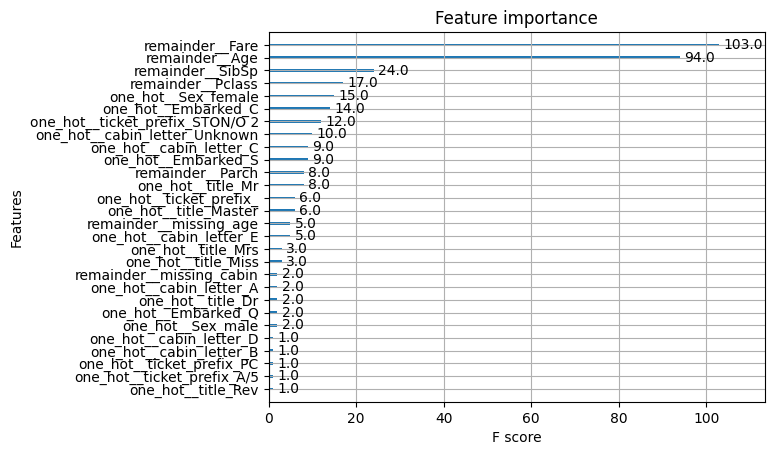

In [36]:
xgb_train_result = xgb.train(parameters, xgb_train, num_boost_round=results.shape[0])
xgb.plot_importance(xgb_train_result)

In [37]:
xgb_test_results = test_X.copy()
xgb_test_results['Survived'] = grid_search_xgb_1.best_estimator_.predict(test_X)
xgb_test_results['Survived'].to_csv('xgb_test_results.csv', index=True)

xgb_test_results2 = test_X.copy()
xgb_test_results2['Survived'] = grid_search_xgb_2.best_estimator_.predict(test_X)
xgb_test_results2['Survived'].to_csv('xgb_test_results2.csv', index=True)

xgb_test_results3 = test_X.copy()
xgb_test_results3['Survived'] = (xgb_train_result.predict(xgb_test) >= 0.5).astype(int)
xgb_test_results3['Survived'].to_csv('xgb_test_results3.csv', index=True)

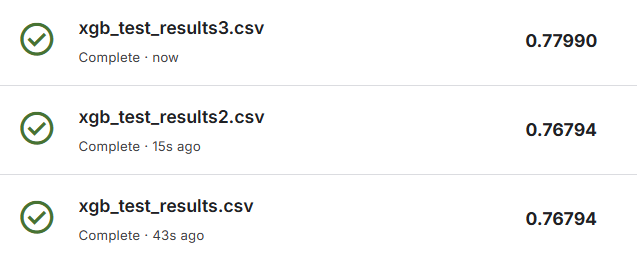

### XGB conclusion
- Adding earlier stopping to grid search doesn't seem to save much time (if any). May be on larger data it could.
- Grid search overfits even though we use kfold. Picking hyperparameters manually gave better score on kaggle.
- Test dataset may contain categorical values that different from train, which results in different one-hot columns being generated. Using column transformer instead of pandas's dummy columns solves the problem.
- I can't make xgb generalize better than standard bagging on kaggle test. Cross-validation and train are better, but kaggle test is worse.

# LightGBM

In [ ]:
# define the lightgbm model (from lightgbm package)
# define the hyperparameters
# train the model
# try to improve the model by changing the hyperparameters on local validation (remember that using gridsearch is a bad idea, because it can't use the early stopping)
# retrain the model on the whole train dataset
# don't forget to specify the number of boosting rounds you found optimal

In [ ]:
# define the catboost model (from catboost package)
# define the hyperparameters
# train the model
# try to improve the model by changing the hyperparameters on local validation (remember that using gridsearch is a bad idea, because it can't use the early stopping)
# retrain the model on the whole train dataset
# don't forget to specify the number of boosting rounds you found optimal

In [ ]:
# compare the results of the three models from this homework and with models from the previous homework
# make a conclusion on which model is better and why
# if your boosting is worse than the RF, try to improve it

In [ ]:
# load test data
# do the same preprocessing as for train data

# using retrained models make predictions on the test data for all new three models
# save the predictions to a file
# upload the predictions to Kaggle and make a submission
# report the score you got and compare it with the score you got on the validation data
# make a conclusion on how well the models generalizes